In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
def load_dataset(dataset_name=None):
    return pd.read_csv(f'data/{dataset_name}')

sec_data = load_dataset('features_30_sec.csv')
data = load_dataset('features_3_sec.csv')
print(data.columns)

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [14]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# For saving models
import joblib

In [4]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           roc_curve, auc)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# For saving models
import joblib

In [68]:
print("\n" + "="*50)
print("PREPROCESSING DATA")
print("="*50)

# Separate features and labels
X = data.drop(['label'], axis=1)

# If 'filename' column exists, save it for later prediction system
if 'filename' in X.columns:
    filenames = X['filename'].copy()
    X = X.drop(['filename'], axis=1)
else:
    filenames = None

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])

print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Classes: {label_encoder.classes_}")


PREPROCESSING DATA
Number of features: 58
Number of samples: 9990
Number of classes: 10
Classes: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [27]:
print("\n" + "="*50)
print("SPLITTING DATA")
print("="*50)

# First split: 70% train+val, 30% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Second split: From the remaining 85%, take 70% for train (which is 70% of total)
# This means we need to take 82.35% of the temp set for training
train_size = 0.70 / 0.85  # This gives us the proportion needed

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=(1-train_size), random_state=42, stratify=y_temp
)


SPLITTING DATA


In [28]:
print("\n" + "="*50)
print("SCALING FEATURES")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")


SCALING FEATURES
Features scaled successfully!


In [ ]:

import time
from datetime import timedelta
from tqdm import tqdm
import numpy as np

print("\n" + "="*60)
print("RANDOM FOREST CLASSIFIER TRAINING AND OPTIMIZATION")
print("="*60)

# Start overall timer
overall_start_time = time.time()

# Initialize Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Define parameter grid for hyperparameter tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Calculate total combinations
total_combinations = len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf'])
total_fits = total_combinations * 5  # 5-fold CV

print(f"Parameter combinations to evaluate: {total_combinations}")
print(f"Cross-validation folds: 5")
print(f"Total model fits required: {total_fits}")
print("Initiating grid search with cross-validation...\n")

# Custom progress callback for GridSearchCV
class ProgressGridSearchCV:
    def __init__(self, estimator, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1):
        self.estimator = estimator
        self.param_grid = param_grid
        self.cv = cv
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.start_time = None
        self.progress_bar = None
        
    def fit(self, X, y):
        from sklearn.model_selection import ParameterGrid
        from sklearn.model_selection import cross_val_score
        from sklearn.base import clone
        
        # Calculate total iterations
        param_combinations = list(ParameterGrid(self.param_grid))
        total_iterations = len(param_combinations)
        
        # Initialize progress bar
        self.progress_bar = tqdm(
            total=total_iterations, 
            desc="Grid Search Progress",
            bar_format="{l_bar}{bar}| {n}/{total} [{elapsed}<{remaining}, {rate_fmt}]",
            ncols=120
        )
        
        self.start_time = time.time()
        
        best_score = -np.inf
        best_params = None
        best_estimator = None
        
        for i, params in enumerate(param_combinations):
            # Create estimator with current parameters
            estimator = clone(self.estimator)
            estimator.set_params(**params)
            
            # Perform cross-validation
            cv_scores = cross_val_score(estimator, X, y, cv=self.cv, scoring=self.scoring, n_jobs=1)
            mean_score = cv_scores.mean()
            
            # Update best if current is better
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
                best_estimator = clone(estimator).fit(X, y)
            
            # Calculate time estimates
            elapsed_time = time.time() - self.start_time
            iterations_completed = i + 1
            avg_time_per_iteration = elapsed_time / iterations_completed
            remaining_iterations = total_iterations - iterations_completed
            estimated_remaining_time = avg_time_per_iteration * remaining_iterations
            
            # Update progress bar with custom postfix
            self.progress_bar.set_postfix({
                'Best Score': f'{best_score:.4f}',
                'ETA': f'{timedelta(seconds=int(estimated_remaining_time))}',
                'Current Score': f'{mean_score:.4f}'
            })
            self.progress_bar.update(1)
            
            # Print detailed progress every 15 iterations
            if self.verbose and (i + 1) % 15 == 0:
                print(f"\nProgress Update: {iterations_completed}/{total_iterations} combinations completed")
                print(f"Estimated time remaining: {timedelta(seconds=int(estimated_remaining_time))}")
                print(f"Current best score: {best_score:.4f}")
                print(f"Current best parameters: {best_params}")
        
        self.progress_bar.close()
        
        # Store results
        self.best_score_ = best_score
        self.best_params_ = best_params
        self.best_estimator_ = best_estimator
        
        return self

# Start grid search timer
grid_search_start_time = time.time()

# Initialize and execute grid search
rf_grid_search = ProgressGridSearchCV(
    rf_classifier, 
    rf_param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Fit on training data
print("Executing hyperparameter optimization...")
rf_grid_search.fit(X_train_scaled, y_train)

# End grid search timer
grid_search_end_time = time.time()
grid_search_duration = grid_search_end_time - grid_search_start_time

print(f"\nGrid search optimization completed successfully")
print(f"Total optimization time: {str(timedelta(seconds=int(grid_search_duration)))}")
print(f"Duration in seconds: {grid_search_duration:.2f}")

# Get best model
rf_best = rf_grid_search.best_estimator_
print(f"\nOptimal Random Forest parameters:")
for param, value in rf_grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"Best cross-validation accuracy: {rf_grid_search.best_score_:.4f}")

# Start evaluation timer
print("\nGenerating predictions on validation dataset...")
eval_start_time = time.time()

# Evaluate on validation set
rf_val_pred = rf_best.predict(X_val_scaled)
rf_val_accuracy = accuracy_score(y_val, rf_val_pred)

# End evaluation timer
eval_end_time = time.time()
eval_duration = eval_end_time - eval_start_time

print(f"Validation set accuracy: {rf_val_accuracy:.4f}")
print(f"Prediction execution time: {eval_duration:.4f} seconds")

# End overall timer
overall_end_time = time.time()
overall_duration = overall_end_time - overall_start_time

print(f"\n" + "="*60)
print("TRAINING SESSION SUMMARY")
print("="*60)
print(f"Total execution time: {str(timedelta(seconds=int(overall_duration)))}")
print(f"Duration in seconds: {overall_duration:.2f}")
print(f"Final model accuracy: {rf_val_accuracy:.4f}")
print("Random Forest training completed successfully")
print("="*60)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import time
from datetime import timedelta

print("\n" + "="*50)
print("TRAINING SVM CLASSIFIER")
print("="*50)

# Display dataset information
print(f"Training set size: {X_train_scaled.shape}")
print(f"Validation set size: {X_val_scaled.shape}")
print(f"Features: {X_train_scaled.shape[1]}, Training samples: {X_train_scaled.shape[0]}")

# Start overall timer
overall_start_time = time.time()
print(f"Overall training started at: {time.strftime('%H:%M:%S', time.localtime(overall_start_time))}")

# Initialize SVM
svm_classifier = SVC(random_state=42, probability=True)

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01]
}

# Calculate total combinations
total_combinations = len(svm_param_grid['C']) * len(svm_param_grid['kernel']) * len(svm_param_grid['gamma'])
print(f"Total parameter combinations to test: {total_combinations}")
print(f"With 5-fold CV, total fits: {total_combinations * 5}")

# Start grid search timer
grid_search_start_time = time.time()
print(f"\nGrid search started at: {time.strftime('%H:%M:%S', time.localtime(grid_search_start_time))}")

# Perform Grid Search
print("Performing Grid Search for SVM...")
print("This may take several minutes depending on dataset size...")

svm_grid_search = GridSearchCV(
    svm_classifier,
    svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1,  # Serial processing as requested
    verbose=2   # Increased verbosity to show progress
)

# Fit on training data
svm_grid_search.fit(X_train_scaled, y_train)

# End grid search timer
grid_search_end_time = time.time()
grid_search_duration = grid_search_end_time - grid_search_start_time

print(f"\nGrid Search completed at: {time.strftime('%H:%M:%S', time.localtime(grid_search_end_time))}")
print(f"Total grid search time: {str(timedelta(seconds=int(grid_search_duration)))}")
print(f"({grid_search_duration:.2f} seconds)")

# Get best model
svm_best = svm_grid_search.best_estimator_
print(f"\nBest SVM parameters: {svm_grid_search.best_params_}")
print(f"Best cross-validation score: {svm_grid_search.best_score_:.4f}")

# Display some additional grid search results
print(f"Number of parameter combinations tested: {len(svm_grid_search.cv_results_['params'])}")
print(f"Average time per parameter combination: {grid_search_duration / len(svm_grid_search.cv_results_['params']):.2f} seconds")

# Start evaluation timer
print(f"\nValidation evaluation started at: {time.strftime('%H:%M:%S')}")
print("Making predictions on validation set...")
eval_start_time = time.time()

# Evaluate on validation set
svm_val_pred = svm_best.predict(X_val_scaled)
svm_val_accuracy = accuracy_score(y_val, svm_val_pred)

# End evaluation timer
eval_end_time = time.time()
eval_duration = eval_end_time - eval_start_time

print(f"SVM Validation Accuracy: {svm_val_accuracy:.4f}")
print(f"Validation prediction time: {eval_duration:.4f} seconds")
print(f"Validation completed at: {time.strftime('%H:%M:%S', time.localtime(eval_end_time))}")

# End overall timer
overall_end_time = time.time()
overall_duration = overall_end_time - overall_start_time

print(f"\nTRAINING COMPLETE!")
print(f"Training completed at: {time.strftime('%H:%M:%S', time.localtime(overall_end_time))}")
print(f"TOTAL EXECUTION TIME: {str(timedelta(seconds=int(overall_duration)))}")
print(f"({overall_duration:.2f} seconds)")

# Summary statistics
print("\n" + "="*30 + " SUMMARY " + "="*30)
print(f"Dataset: {X_train_scaled.shape[0]} training samples, {X_train_scaled.shape[1]} features")
print(f"Best parameters: {svm_grid_search.best_params_}")
print(f"Best CV score: {svm_grid_search.best_score_:.4f}")
print(f"Validation accuracy: {svm_val_accuracy:.4f}")
print(f"Total training time: {str(timedelta(seconds=int(overall_duration)))}")
print("="*68)

In [81]:
print("\n" + "="*50)
print("MODEL COMPARISON ON VALIDATION SET")
print("="*50)

models = {
    'Random Forest': (rf_best, rf_val_pred),
    'SVM': (svm_best, svm_val_pred)
}

for name, (model, predictions) in models.items():
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_val, predictions):.4f}")
    print(f"Precision: {precision_score(y_val, predictions, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_val, predictions, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_val, predictions, average='weighted'):.4f}")



MODEL COMPARISON ON VALIDATION SET

Random Forest Results:
Accuracy: 0.8465
Precision: 0.8494
Recall: 0.8465
F1-Score: 0.8457

SVM Results:
Accuracy: 0.9099
Precision: 0.9103
Recall: 0.9099
F1-Score: 0.9093


In [82]:
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

# Choose the best model based on validation accuracy
if rf_val_accuracy > svm_val_accuracy:
    best_model = rf_best
    best_model_name = "Random Forest"
else:
    best_model = svm_best
    best_model_name = "SVM"

print(f"\nBest model: {best_model_name}")

# Final evaluation on test set
test_predictions = best_model.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nTest Set Results for {best_model_name}:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision_score(y_test, test_predictions, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, test_predictions, average='weighted'):.4f}")
print(f"F1-Score: {f1_score(y_test, test_predictions, average='weighted'):.4f}")



FINAL EVALUATION ON TEST SET

Best model: SVM

Test Set Results for SVM:
Accuracy: 0.9091
Precision: 0.9095
Recall: 0.9091
F1-Score: 0.9088


In [83]:
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)

print(classification_report(y_test, test_predictions, 
                          target_names=label_encoder.classes_))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       blues       0.89      0.92      0.90       120
   classical       0.92      0.94      0.93       120
     country       0.84      0.85      0.85       120
       disco       0.94      0.91      0.92       120
      hiphop       0.92      0.92      0.92       119
        jazz       0.90      0.94      0.92       120
       metal       0.94      0.93      0.94       120
         pop       0.91      0.90      0.90       120
      reggae       0.91      0.96      0.93       120
        rock       0.92      0.82      0.87       120

    accuracy                           0.91      1199
   macro avg       0.91      0.91      0.91      1199
weighted avg       0.91      0.91      0.91      1199



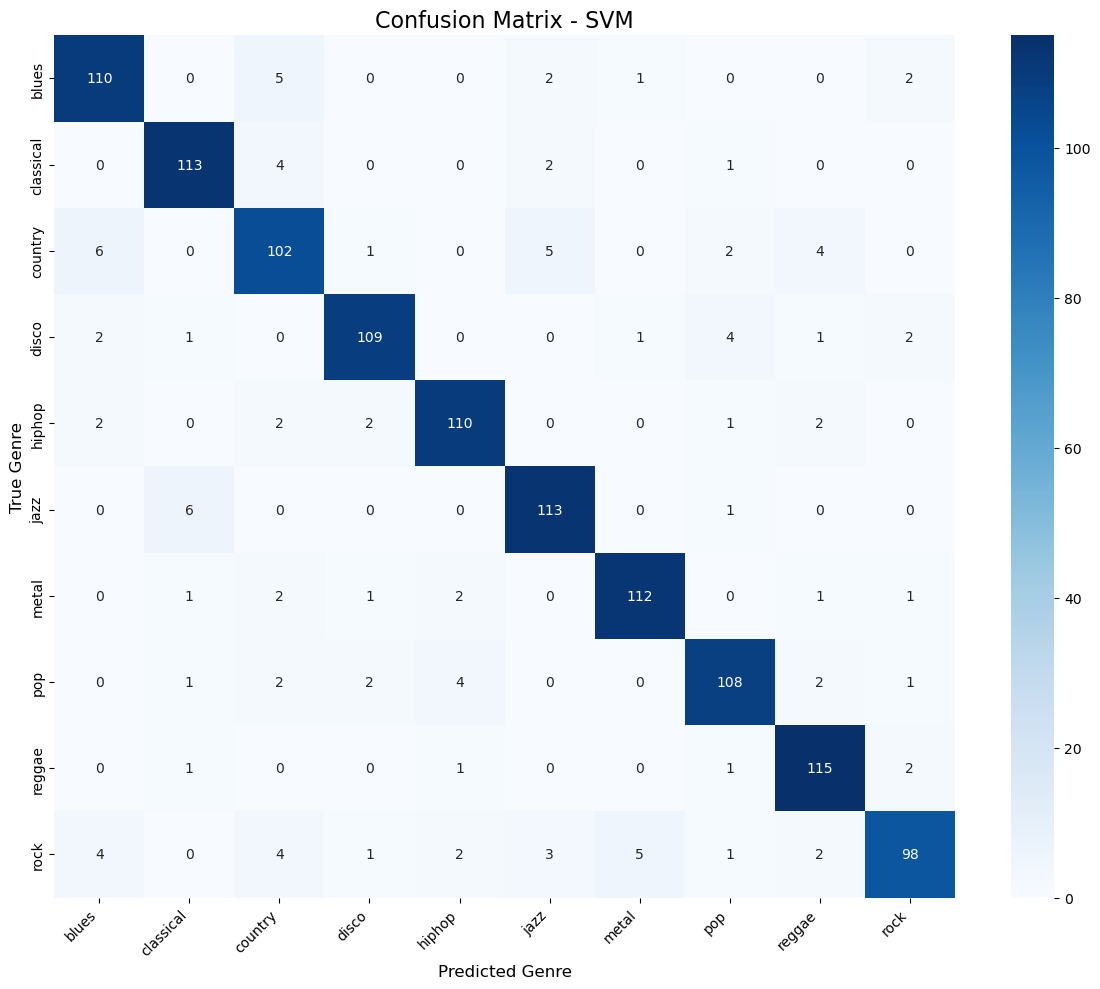

In [84]:
plt.figure(figsize=(12, 10))

# Create confusion matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.xlabel('Predicted Genre', fontsize=12)
plt.ylabel('True Genre', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [85]:
print("\n" + "="*50)
print("SAVING MODELS")
print("="*50)

# Save the best model
joblib.dump(best_model, 'best_model.pkl')

# Save both models for comparison
joblib.dump(rf_best, 'random_forest_model.pkl')
joblib.dump(svm_best, 'svm_model.pkl')

# Save the scaler and label encoder
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


SAVING MODELS


['label_encoder.pkl']

In [3]:
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)

print("Models and preprocessors saved successfully!")

NameError: name 'pickle' is not defined

In [5]:
print("\n" + "="*50)
print("CREATING PREDICTION SYSTEM")
print("="*50)

def predict_genre(song_name, features_df=None):
    """
    Predict the genre of a song given its name.
    
    Parameters:
    song_name: str - Name of the song
    features_df: DataFrame - DataFrame containing features for all songs (optional)
    
    Returns:
    dict - Prediction results with genre and confidence
    """
    
    # Load saved components
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('scaler.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    
    with open('feature_names.pkl', 'rb') as f:
        feature_names = pickle.load(f)
    
    # If no features_df provided, try to load from the original data
    if features_df is None:
        features_df = pd.read_csv('music_features.csv')
    
    # Find the song
    if 'filename' in features_df.columns:
        song_data = features_df[features_df['filename'].str.contains(song_name, case=False)]
    else:
        print("No filename column found. Please provide song features directly.")
        return None
    
    if song_data.empty:
        print(f"Song '{song_name}' not found in the dataset.")
        return None
    
    # Extract features
    song_features = song_data[feature_names].iloc[0].values.reshape(1, -1)
    
    # Scale features
    song_features_scaled = scaler.transform(song_features)
    
    # Make prediction
    prediction = model.predict(song_features_scaled)[0]
    prediction_proba = model.predict_proba(song_features_scaled)[0]
    
    # Get genre name
    predicted_genre = label_encoder.inverse_transform([prediction])[0]
    
    # Get confidence scores for all genres
    genre_confidences = {}
    for i, genre in enumerate(label_encoder.classes_):
        genre_confidences[genre] = prediction_proba[i]
    
    # Sort by confidence
    sorted_confidences = sorted(genre_confidences.items(), 
                               key=lambda x: x[1], reverse=True)
    
    result = {
        'song_name': song_name,
        'predicted_genre': predicted_genre,
        'confidence': genre_confidences[predicted_genre],
        'all_probabilities': sorted_confidences
    }
    
    return result


CREATING PREDICTION SYSTEM


In [7]:
print("\nTesting prediction system...")

# Example usage (replace with actual song names from your dataset)
test_songs = ['hiphop.00087', 'jazz.00043', 'pop.00097']  # Adjust based on your filename format

for song in test_songs:
    result = predict_genre(song, data)
    if result:
        print(f"\nSong: {result['song_name']}")
        print(f"Predicted Genre: {result['predicted_genre']}")
        print(f"Confidence: {result['confidence']:.4f}")
        print("Top 3 genre probabilities:")
        for genre, prob in result['all_probabilities'][:3]:
            print(f"  {genre}: {prob:.4f}")


Testing prediction system...

Song: hiphop.00087
Predicted Genre: hiphop
Confidence: 0.9889
Top 3 genre probabilities:
  hiphop: 0.9889
  metal: 0.0096
  reggae: 0.0014

Song: jazz.00043
Predicted Genre: jazz
Confidence: 0.8526
Top 3 genre probabilities:
  jazz: 0.8526
  classical: 0.0434
  pop: 0.0302

Song: pop.00097
Predicted Genre: pop
Confidence: 0.9630
Top 3 genre probabilities:
  pop: 0.9630
  hiphop: 0.0145
  reggae: 0.0077
